[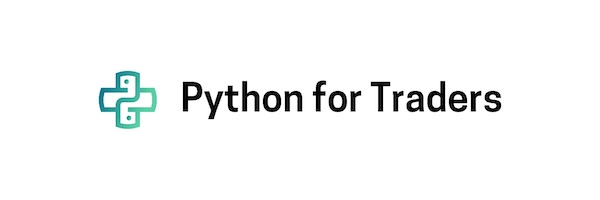](https://pythonfortraders.io)

# Introduction to Monte Carlo Simulations

Monte Carlo simulations are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

## Basic Concepts
Monte Carlo simulations rely on random variables and distributions. The process involves generating random samples from a probability distribution to simulate the behavior of complex systems or processes.

Let's say the random variable was the roll of a 6-sided die. It's easy to get the expected value of this random variable as (1 + 2 + 3 + 4 + 5 + 6) / 6 = 3.5, but suppose we couldn't calculate it outright. We could use a Monte Carlo simulation to roll the die thousands of times, track the results, and assess the distribution of them.

Expected Value of a Dice Roll: 3.495774


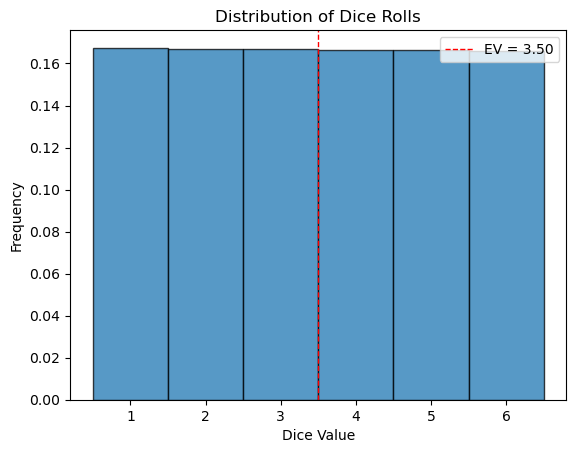

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Number of simulations
num_simulations = 1_000_000

# Simulate dice rolls
rolls = np.random.randint(1, 7, num_simulations)

# Calculate expected value
expected_value = np.mean(rolls)

print(f"Expected Value of a Dice Roll: {expected_value}")

# Plot distribution
plt.hist(rolls, bins=np.arange(0.5, 7.5, 1), density=True, edgecolor='black', alpha=0.75)
plt.axvline(expected_value, color='red', linestyle='dashed', linewidth=1, label=f'EV = {expected_value:.2f}')
plt.title('Distribution of Dice Rolls')
plt.xlabel('Dice Value')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))
plt.legend()
plt.show()

You can even use Monte Carlo simulations to estimate $\pi$ by randomly generating points from -1 to 1 and counting how many of them fall within the unit circle. Let's say we have a square from -1 to 1 on both the x and y axes centered at 0, so it's side length is 2 and area is 4. Then the ratio of the area of the circle to the area of the square is $\pi / 4$, which is proportional to the number of points in the circle over the number of total points. 

That means we can estimate `pi = 4 * num_points_in_circle / total_points` in the simulation below.

Estimated Pi: 3.128


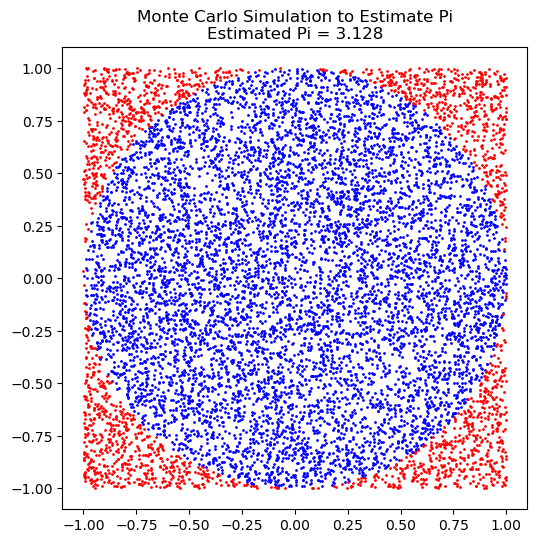

In [2]:
# Number of random points
num_points = 10000

# Generate random points
x = np.random.uniform(-1, 1, num_points)
y = np.random.uniform(-1, 1, num_points)

# Calculate distance from origin
distance = np.sqrt(x**2 + y**2)

# Points inside the circle
inside_circle = distance <= 1

# Estimate Pi
pi_estimate = 4 * np.sum(inside_circle) / num_points

print(f"Estimated Pi: {pi_estimate}")

# Plotting the points
plt.figure(figsize=(6,6))
plt.scatter(x[inside_circle], y[inside_circle], color='blue', s=1)
plt.scatter(x[~inside_circle], y[~inside_circle], color='red', s=1)
plt.title(f"Monte Carlo Simulation to Estimate Pi\nEstimated Pi = {pi_estimate}")
plt.show()

## Monte Carlo Simulations in Finance
Monte Carlo methods are widely used in finance for tasks such as stock price simulation and option pricing.

### Simulating Brownian Motion

Stock prices are often simulated using Geometric Brownian motion, like a random walk with drift and volatility, described by the equation below. 

$$\frac{dS}{S} = \mu dt + \sigma dW$$

That equation is a stochastic differential equation describing the change in the process over time. To actually compute the price at a given time, it can be solved for the following expression: 

$$S_t = S_0 \exp{(\mu - 0.5 \sigma^2)dt + \sigma N(0,1) \sqrt{dt} }$$

where:
* $\mu$ is the expected returns
* $\sigma$ is the volatility 
* $N(0,1)$ is a normally distributed random variable
* $S_0$ is the initial price

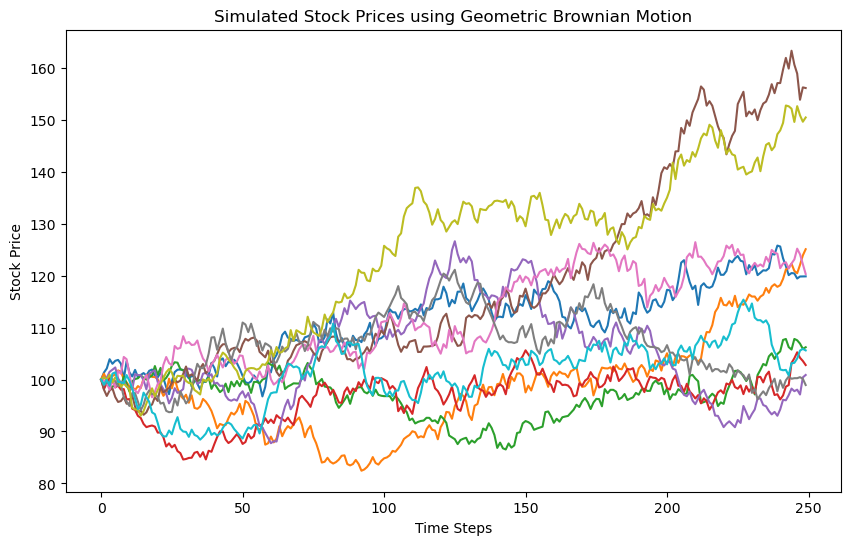

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
mu = 0.1  # Expected return
sigma = 0.2  # Volatility
T = 1.0  # Time period (1 year)
num_steps = 250  # Number of time steps
num_simulations = 1000  # Number of simulations

# Time increment
dt = T / num_steps

# Simulate stock prices
S = np.zeros((num_steps, num_simulations))
S[0] = S0
for t in range(1, num_steps):
    Z = np.random.standard_normal(num_simulations)
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plot simulations
plt.figure(figsize=(10,6))
plt.plot(S[:, :10])  # Plot first 10 simulations
plt.title("Simulated Stock Prices using Geometric Brownian Motion")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

### Simulating Option Prices

In [4]:
import numpy as np

# Parameters
S0 = 100  # Initial stock price
K = 105  # Strike price
T = 1.0  # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
num_simulations = 10000  # Number of simulations

# Simulate end-of-period stock prices
Z = np.random.standard_normal(num_simulations)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Calculate payoffs
payoff = np.maximum(ST - K, 0)

# Discount payoffs to present value
option_price = np.exp(-r * T) * np.mean(payoff)

print(f"Estimated Call Option Price: {option_price}")

Estimated Call Option Price: 7.806850165041802


## Improving Performance with Concurrency

Part of any MC is running a simulation thousands, even millions of time. We can speed this up by doing it concurrently, so all the simulations run at the same time rather than one after the other. 

How it works now:
* Create a thread pool executor with 4 workers.
* Submit the `simulate_stock_price` function to the executor with the given parameters, dividing the total number of simulations equally among the workers.
* Get a list of future objects representing the parallel tasks.
* Collect the results of the completed tasks into a new list. 

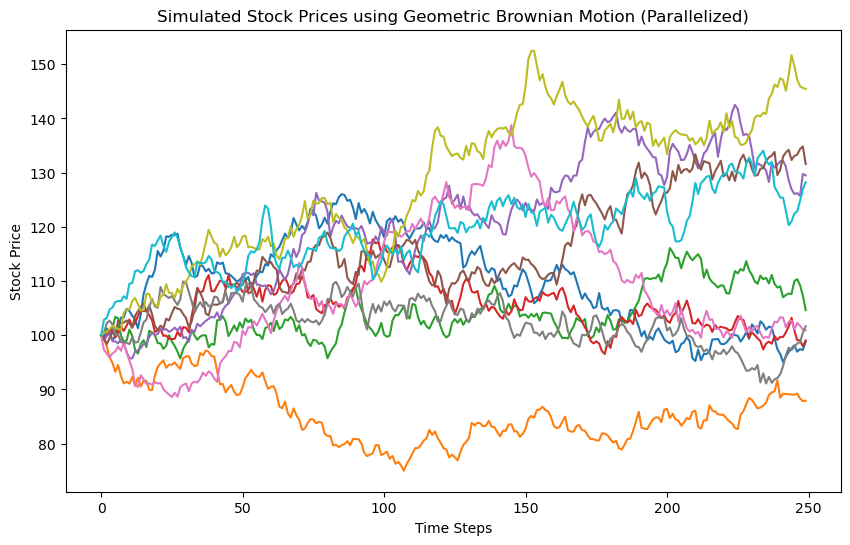

In [5]:
import concurrent.futures

def simulate_stock_price(S0, mu, sigma, T, num_steps, num_simulations):
    dt = T / num_steps
    S = np.zeros((num_steps, num_simulations))
    S[0] = S0
    for t in range(1, num_steps):
        Z = np.random.standard_normal(num_simulations)
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

# Parameters
S0 = 100
mu = 0.1
sigma = 0.2
T = 1.0
num_steps = 250
num_simulations = 1000
num_workers = 4

# Run simulations in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(simulate_stock_price, S0, mu, sigma, T, num_steps, num_simulations // num_workers) 
               for _ in range(num_workers)]
    results = [future.result() for future in concurrent.futures.as_completed(futures)]

# Combine results
S = np.concatenate(results, axis=1)

# Plot simulations
plt.figure(figsize=(10,6))
plt.plot(S[:, :10])  # Plot first 10 simulations
plt.title("Simulated Stock Prices using Geometric Brownian Motion (Parallelized)")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()